In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd

from scipy.special import gamma
from scipy.stats import invweibull as frechet
def myGamma(zeta):
    return gamma(1-1/zeta)

DIR = r"/home/cz/Dropbox/Summer RA Model EP/Parameters/"


class Params(object):
    pass

def read(name):
    myfile = os.path.join(DIR, 'ep_{}.csv'.format(name))
    df=pd.read_csv(myfile, header=None)
    return df

def pv(name, mat):
    print("{}: {}".format(name.rjust(10), mat.shape))
    
def read_matrix(name, verbose=True):
    df = read(name)
    mat = df.values
    if verbose:
        pv(name, mat)
    return mat

def read_params():
    param = Params()
    with open(os.path.join(DIR, 'ep_params.csv')) as f:
        lines = f.readlines()
        values = lines[0].split(',')
        names = lines[2].replace('[','').replace(']','').strip().split(' ')

        if len(values) != len(names):
            print('not sure how to read this...')
            print(lines)

        print('Found {} parameters'.format(len(values)))    
        for k,v in zip(names, values):
            print('{} = {}'.format(k,v))
            setattr(param, k.split('.')[1], float(v))
    
    return param

In [2]:
param = read_params()

Found 13 parameters
param.beta = 0.28818
param.q = 0.67565
param.mu = 3.4112
param.zeta = 1.62
param.alpha = 0.05
param.sigma = 4
param.psi = 0.76551
param.delta = 0.91803
param.eta = 0.35
param.gamma = 0.35055
param.nu = 0.0187
param.kappa = 0.42
param.r = 2.8866



In [3]:
myGamma(param.zeta)

2.3211529336709016

In [4]:
skills, wages = read_matrix("skill1880"), read_matrix("wage1880")
Q_A, Q_NA = read_matrix("Q_A"), read_matrix("Q_NA")

Z = read_matrix("Z")
vA = read_matrix("vA")
Capital = read_matrix("Capital")
phi = read_matrix("phi")

tau = read_matrix("tau")
amenities = read_matrix("amenities")

 skill1880: (645, 2)
  wage1880: (645, 2)
       Q_A: (645, 5)
      Q_NA: (645, 5)
         Z: (5, 2)
        vA: (5, 1)
   Capital: (5, 1)
       phi: (4, 1)
       tau: (645, 645)
 amenities: (645, 5)


## Mess with the variables a bit

In [5]:
# expand the axes
skills = np.expand_dims(skills, 2).transpose((2,1,0))
pv("skills", skills)

wages = np.expand_dims(wages, 2).transpose((2,1,0))
pv("wages", wages)

Q = np.stack((Q_A, Q_NA), axis=1).transpose((2,1,0))
pv("Q", Q)

vA = vA.flatten()
vAt= np.array([vA[1], 1-vA[1]]).reshape(2,1)
pv("vAt", vAt)

Capital = Capital.flatten()
pv("Capital", Capital)

pv("tau", tau)

amenities = amenities.transpose((1,0))
pv("amenities", amenities)

    skills: (1, 2, 645)
     wages: (1, 2, 645)
         Q: (5, 2, 645)
       vAt: (2, 1)
   Capital: (5,)
       tau: (645, 645)
 amenities: (5, 645)


In [6]:
# define some constants for indexing
t = 0
A, NA = 0,1
L, H = 0,1
R,S,T = 2,1,0

Psi = np.array([[1,1],
                [1,1.6]])

In [7]:
overall_lamda = np.sum(skills, axis=R) # this is \lambda overall
Lrt = np.sum(skills, axis=S)
lam_rt = (skills/Lrt)

print(overall_lamda.shape, Lrt.shape, lam_rt.shape)

# now we can do things like this:
np.sum(Lrt * lam_rt, axis=R)

(1, 2) (1, 645) (1, 2, 645)


array([[0.7046579 , 0.29534209]])

The majorit of commuting zones had agricultural employment shares exceeding 75% in 1880...

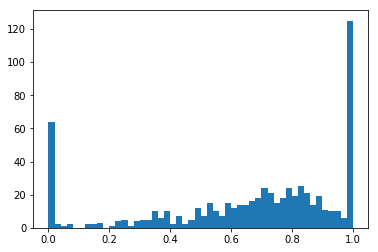

In [8]:
plt.hist(lam_rt[t,A], bins=50)
plt.show()

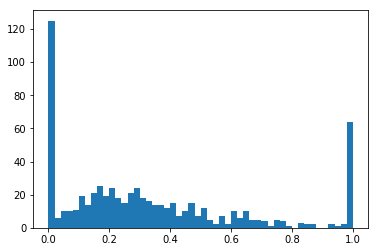

In [9]:
plt.hist(lam_rt[t,NA], bins=50)
plt.show()

In [10]:
np.sum(lam_rt[t,NA] > .99), np.sum(lam_rt[t,NA] < .01)

(63, 122)

# Define methods

Old:
```
regionalRevenue = (1-param.alpha) * pi[A] * vA[1] * GDP
regionalEarnings = Lrt * myGamma(param.zeta) * (lam_rt[t,L] * Psi[L,A] + lam_rt[t,H] * Psi[H,A])

newWages = regionalRevenue / regionalEarnings

regionalRevenue_NA = (1-param.alpha) * pi[NA] * (1 - vA[1]) * GDP
regionalEarnings_NA = Lrt * myGamma(param.zeta) * (lam_rt[t,L] * Psi[L,NA] + lam_rt[t,H] * Psi[H,NA])

newWages_NA = regionalRevenue_NA / regionalEarnings_NA
```

New:
```
regionalRevenue = (1-param.alpha) * pi * vAt *  GDP
x = Lrt * myGamma(param.zeta) * np.matmul(lam_rt.transpose((2,0,1)), Psi).transpose((1,2,0))

newWages = regionalRevenue/x
```

Is it faster? I don't know if it's easier to read...

In [11]:
# useful for resets
def readWages(verbose=False):
    wages = read_matrix("wage1880", verbose)
    wages = np.expand_dims(wages, 2).transpose((2,1,0))
    return wages

def readSkills():
    skills = read_matrix("skill1880")
    skills = np.expand_dims(skills, 2).transpose((2,1,0))
    return skills


def psi(r):
    n = param.eta
    ret = 1 + (param.beta**(1/(1-n))) * ((1+r)**(n/(1-n)))
    return 1/ret

interest_rate = param.r
consumption_share = psi(interest_rate)

aa = myGamma(param.eta/param.zeta)/param.eta
bb = consumption_share**(param.eta-1)

print(interest_rate, consumption_share, aa,bb)


def computePi(wages):
    pi = Q[t]**(param.sigma-1) * wages**((1-param.alpha)*(1-param.sigma))
    # pi has shape (1, 2, 645)
    normalize = np.sum(pi, axis=R)
    
    # normalize has shape (1,2)
    normalize = np.expand_dims(normalize, 2)
    pi = pi / (normalize ** (1/(1-param.sigma)))
    return pi

def computeTheta(wages):
    Theta = np.matmul(Psi, wages**(param.zeta)) ** (1/param.zeta)
    Theta_l = Theta[0,L]
    Theta_h = Theta[0,H]
    return Theta_h, Theta_l, Theta

def computeGDP(lam_rt, Theta_h, Theta_l):
    constant= 1/(1-param.alpha) * myGamma(param.zeta)
    GDP = constant * np.sum(Lrt * (lam_rt * Theta_h + (1-lam_rt) * Theta_l))
    return GDP
    

2.8866 0.7655096595807223 0.7005475951092922 1.1896852061132865


Text(0,0.5,'pi')

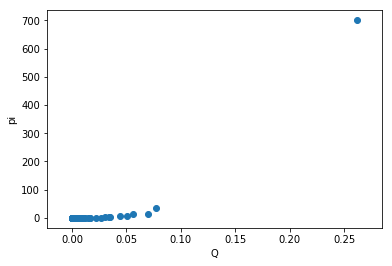

In [12]:
pi = computePi(wages)
plt.scatter(Q[t,NA], pi[t,NA])
plt.xlabel('Q'); plt.ylabel('pi')

In [13]:
def computeLrt(skills):
    overall_lamda = np.sum(skills, axis=R)
    Lrt = np.sum(skills, axis=S)
    lam_rt = (skills/Lrt)
    
    return overall_lamda, Lrt, lam_rt


def loopy(skills, wages, log=True):
    lr = 0.1
    loss = 10
    
    # these are fixed
    lamda, Lrt, lam_rt = computeLrt(skills)
    
    for i in range(1000):

        pi = computePi(wages)
        Theta_h, Theta_l, Theta = computeTheta(wages)
        GDP = computeGDP(lam_rt, Theta_h, Theta_l)

        regionalRevenue = (1-param.alpha) * pi * vAt *  GDP
        x = Lrt * myGamma(param.zeta) * np.matmul(lam_rt.transpose((2,0,1)), Psi).transpose((1,2,0))

        newWages = regionalRevenue/x
        
        # normalize wages
        newWages = newWages / np.sum(newWages)
        
        loss = np.sum(np.abs(newWages - wages))

        # update
        wages = lr * newWages + (1-lr) * wages
        
        if loss < 1e-6:
            if log:
                print('Iteration #{}: {}'.format(i, loss))
            break
            
        if i % 20 == 0 and log:
            print('Iteration #{}: {}'.format(i, loss))
            
    return wages


Iteration #0: 27.73479004410282
Iteration #20: 3.1970523791273604
Iteration #40: 0.3886869328051251
Iteration #60: 0.04725525697351689
Iteration #80: 0.0057451360546579705
Iteration #100: 0.000698474421693193
Iteration #120: 8.491818350673615e-05
Iteration #140: 1.032406866487378e-05
Iteration #160: 1.2551657302962706e-06
Iteration #163: 9.150158173722074e-07


Text(0,0.5,'log Non-Agricultural wages')

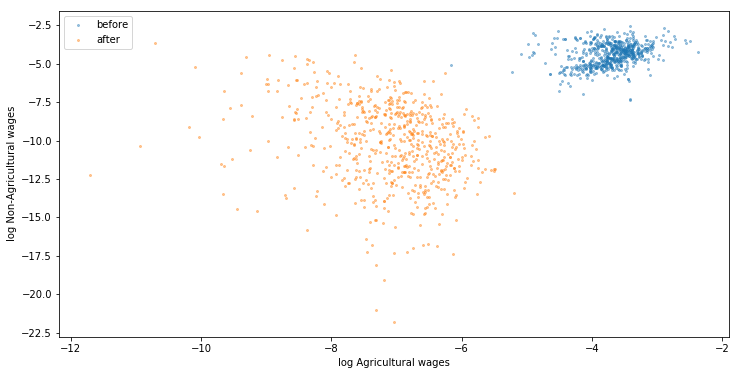

In [14]:
wages = readWages()

def draw(wages):
    plot_params = {
        'alpha': 0.4,
        's': 4
    }
    
    plt.scatter(np.log(wages[t,A]), np.log(wages[t,NA]),
           **plot_params)
    
    
plt.figure(figsize=(12,6))

# before
draw(wages)

newWages = loopy(skills, wages)

# after
draw(newWages)
plt.legend(['before', 'after'])
plt.xlabel('log Agricultural wages'); plt.ylabel('log Non-Agricultural wages')

This is the plot that I'm not sure about. Are the wages for Non-Agricultural sectors supposed to be bunched near 0?

## Incorporating mobility

In [15]:
def computeMobility(wages):
    _,_,Theta = computeTheta(wages)    
    expectedUtility = myGamma(param.zeta)*Theta
    
    # since the interest rate is a constant, we can take psi(r_{t+1}) to be a constant too
    W_rt = aa*bb * expectedUtility**param.eta + amenities[1] # amenities in 1910

    # tau is indexed like j x r
    stuff = np.expand_dims(W_rt, 2) - tau

    sums = np.sum(np.exp(1/param.kappa * stuff), axis=3) # across the R's, not the j's
    sums = np.expand_dims(sums, 3)

    movingProbs = np.exp(1/param.kappa * stuff)/sums 
    oldL = np.expand_dims((Lrt*lam_rt), axis=3)
    new = np.sum(movingProbs * oldL, axis=2)
    
    return new

newSkills = computeMobility(wages)
np.sum(newSkills, axis=R) # note that the overall lambda stays the same... since we didn't change that part

array([[0.7046579 , 0.29534209]])

 skill1880: (645, 2)
L---- #0: 0.3238827080469677
0.4938385486602783 seconds


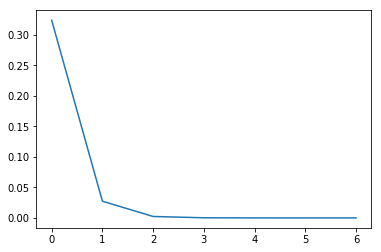

In [16]:
import time
start = time.time()

lr = 0.9
losses = []

wages  = readWages()
skills = readSkills()

for i in range(1000):
    
    # find a fixed point wage, given location
    wages = loopy(skills, wages, log=False)
    
    # find the new locations, given the wage
    newSkills = computeMobility(wages)
    
    loss = np.sum(np.abs(newSkills - skills))
    losses.append(loss)
    
    skills = lr * newSkills + (1-lr)*skills
    
    if loss < 1e-6:
        break
    
    if i % 10 == 0:
        print('L---- #{}: {}'.format(i, loss))
        
print(time.time() - start, 'seconds')
plt.plot(losses)

 skill1880: (645, 2)


Text(0,0.5,'log high-skill')

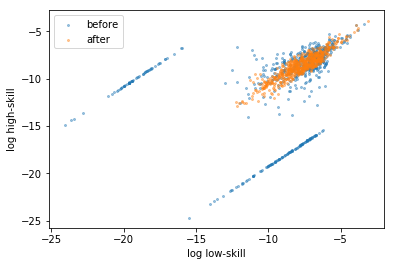

In [17]:
oldSkills = readSkills()

draw(oldSkills)
draw(skills)
plt.legend(['before', 'after'])
plt.xlabel('log low-skill'); plt.ylabel('log high-skill')

Text(0,0.5,'log Non-Agricultural wages')

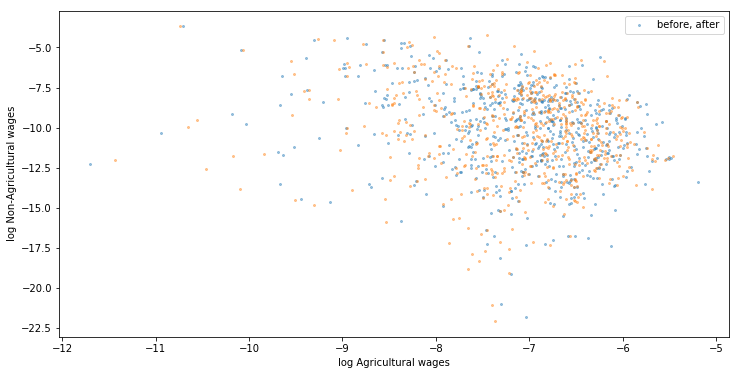

In [18]:
plt.figure(figsize=(12,6))

draw(newWages) # way back when... before we updated locations
draw(wages) # this is the actual result
plt.legend(['before, after'])
plt.xlabel('log Agricultural wages'); plt.ylabel('log Non-Agricultural wages')

In [20]:
# we don't any new wages with this location
nex = loopy(skills, wages)

Iteration #0: 5.758583431656209e-07


In [21]:
# and we don't get any new locations either
locs = computeMobility(nex)

# the new locations and the one we get are the same
np.sum(np.abs(locs - skills))

1.2845328237866974e-08

They definitely converged... 

## Are these the 1910 wages and locations?

In [25]:
Lrt = np.sum(skills, axis=S)
Theta_h,Theta_l, Theta = computeTheta(wages)

GDP = computeGDP(Lrt,Theta_h, Theta_l)
capital = param.alpha * GDP
capital

0.0005597218673515321

In [26]:
Capital

array([0.020693, 0.037483, 0.067895, 0.12298 , 0.22277 ])

## How about we compute the aggregate decline in agricultural employment?

In [27]:
# todo